# 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
from statistics import mean
import string
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# 2. Get data and take a quick look

In [ ]:
data = pd.read_csv('https://drive.google.com/uc?id=1lhGzuaw07s6MKjv2LSlxyQ_ZwBrXPyRB')
data = data[['text', 'target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.drop_duplicates()
data.shape

(7613, 2)

### 2.1 Number of tweets on each label

There some text are mislabeled, so first we need to relabel them

In [ ]:
df_mislabeled = data.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled

text
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                  2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!                             2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                             2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!                                         2
To fight bioterrorism sir.                                                                                                                     2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE    2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption        

In [ ]:
data.loc[data['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target'] = 0
data.loc[data['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target'] = 0
data.loc[data['text'] == 'To fight bioterrorism sir.', 'target'] = 0
data.loc[data['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target'] = 1
data.loc[data['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target'] = 1
data.loc[data['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target'] = 0
data.loc[data['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target'] = 0
data.loc[data['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target'] = 1
data.loc[data['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target'] = 1
data.loc[data['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target'] = 0
data.loc[data['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target'] = 0
data.loc[data['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target'] = 0
data.loc[data['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target'] = 0
data.loc[data['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target'] = 0
data.loc[data['text'] == "Caution: breathing may be hazardous to your health.", 'target'] = 1
data.loc[data['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target'] = 0
data.loc[data['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target'] = 0
data.loc[data['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target'] = 0

In [ ]:
targets = data['target'].value_counts()
targets

0    4354
1    3259
Name: target, dtype: int64

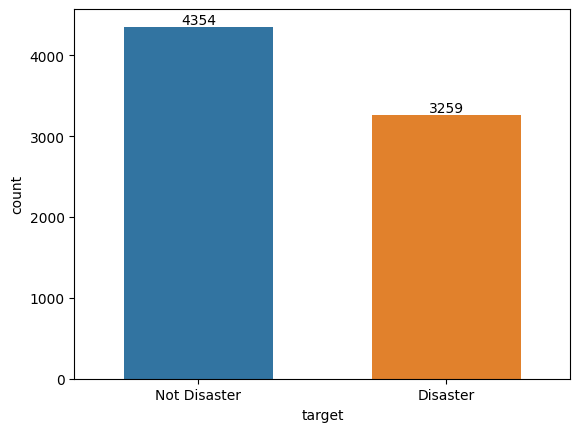

In [ ]:
sns.countplot(data, x='target', width=0.6)

ax = plt.gca()
ax.set_xticklabels(['Not Disaster', 'Disaster'])
plt.ylabel("count")
for label in ax.containers:
    ax.bar_label(label)
plt.show()

### 2.2 Look at several tweets that anounce disaster and not

Tweets about disaster

In [ ]:
disaster_tweets = data[data['target'] == 1]['text'].values[:5]
for tweet in disaster_tweets:
  print(tweet)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


Tweet not about disaster

In [ ]:
not_disaster_tweets = data[data['target'] == 0]['text'].values[:5]
for tweet in not_disaster_tweets:
  print(tweet)

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


# 3. Text preprocessing

We will clean text data with following steps:
  1. Correct typos and slang
  2. Expand contractions and informal abbreviations
  3. Remove stop words, url, mention, html tag, email, non ascii characters, etc...
  4. Stemmize and Lemmitize

### Split text and label

In [ ]:
shuffed_index = np.random.permutation(np.arange(0, len(data)))
data = data.iloc[shuffed_index]
X_train, y_train = data[['text']].copy(), data['target']
X_train.head()

,text
6036,Agency seeks comments on seismic permits http:...
726,Keep thinking about it until I stepped on a br...
4567,If you're slating @gpaulista5 for @JackWilsher...
2175,#?? #???? #??? #??? MH370: Aircraft debris fou...
532,Musician Kalle Mattson Recreates 34 Classic Al...


### 3.1 Correct typos and slang

In [ ]:
class CorrectTyposAndSlang(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def correct_typos_and_slang(self, tweet):
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"10:38PM", "", tweet)
    tweet = re.sub(r"10:30pm", "", tweet)
    tweet = re.sub(r"yr", "year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    return tweet

  def transform(self, X, y=None):
    X.loc[:,'text'] = X['text'].apply(lambda x: self.correct_typos_and_slang(x))
    return X

In [ ]:
ctas = CorrectTyposAndSlang()
X_tmp = ctas.fit_transform(X_train[:5].copy())
X_tmp.head()

,text
6036,Agency seeks comments on seismic permits http:...
726,Keep thinking about it until I stepped on a br...
4567,If you're slating @gpaulista5 for @JackWilsher...
2175,#?? #???? #??? #??? MH370: Aircraft debris fou...
532,Musician Kalle Mattson Recreates 34 Classic Al...


### 3.2 Expand contractions and informal abbreviations

In [ ]:
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.3 MB/s eta 0:00:00


In [ ]:
import contractions

class ExpandContractions(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def expand_contractions_and_informal_abbreviations(self, tweet):
    tweet = contractions.fix(tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)
    return tweet

  def transform(self, X, y=None):
    X.loc[:, 'text'] = X['text'].apply(lambda x: self.expand_contractions_and_informal_abbreviations(x))
    return X

In [ ]:
ec = ExpandContractions()
X_tmp = ec.fit_transform(X_tmp)
X_tmp.head()

,text
6036,Agency seeks comments on seismic permits http:...
726,Keep thinking about it until I stepped on a br...
4567,If you are slating @gpaulista5 for @JackWilshe...
2175,#?? #???? #??? #??? MH370: Aircraft debris fou...
532,Musician Kalle Mattson Recreates 34 Classic Al...


### 3.3 Remove stop words, mention, urls, email, etc...

In [ ]:
class RemoveNoise(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def remove_noise(self, tweet) :
    # remove mentions
    tweet = re.sub(r'@\w*', '' , tweet)
    # remove_urls
    tweet = re.sub(r'https?://\S+', '', tweet)
    # remove special characters
    tweet = re.sub(r"[^a-zA-Z0-9\s]", ' ', tweet)
    # remove escape characters
    tweet = re.sub(r"\\",'',tweet)
    # remove extra spaces
    tweet = re.sub(r"\s{2,}",' ', tweet)
    # remove newline characters
    tweet = re.sub(r"\n", " ", tweet)
    # remove stop words
    tweet = " ".join(word for word in tweet.split() if word not in STOPWORDS)
    # remove number
    tweet = re.sub(r'\d+', '', tweet)
    # remove punctuations
    for p in string.punctuation:
          tweet = tweet.replace(p, '')
    # remove words have one character
    tweet = " ".join(word for word in tweet.split() if len(word) > 1)
    # remove character entity references
    tweet = re.sub(r"gt", "", tweet)
    tweet = re.sub(r"lt", "", tweet)
    tweet = re.sub(r"amp", "", tweet)
    # lower tweet
    tweet = tweet.lower()
    return tweet

  def transform(self, X, y=None):
    X.loc[:, 'text'] = X['text'].apply(lambda x: self.remove_noise(x))
    return X

In [ ]:
rn = RemoveNoise()
X_tmp = rn.fit_transform(X_tmp)
X_tmp.head()

,text
6036,agency seeks comments seismic permits
726,keep thinking stepped broken glass pun tak sed...
4567,if slating injury disgrace afc fan base injuri...
2175,mh aircraft debris found la reunion missing ma...
532,musician kalle mattson recreates classic album...


### 3.4 Stemmize and Lemmatize

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

class StemAndLemitize(BaseEstimator, TransformerMixin):
  def __init__(self, accept=True):
    self.accept = accept

  def fit(self, X, y=None):
    return self

  def stemmize_and_lemmitize(self, tweet):
    if self.accept:
      # stemmerize and lemmatize word
      stemmer = PorterStemmer()
      lemmatizer = WordNetLemmatizer()
      tweet = " ".join(stemmer.stem(word) for word in tweet.split())
      tweet = [lemmatizer.lemmatize(word) for word in tweet.split()]
      tweet = " ".join(tweet)
    return tweet

  def transform(self, X, y=None):
    X.loc[:, 'text'] = X['text'].apply(lambda x: self.stemmize_and_lemmitize(x))
    return X

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
stlm = StemAndLemitize()
X_tmp = stlm.fit_transform(X_tmp)
X_tmp.head()

,text
6036,agenc seek comment seismic permit
726,keep think step broken glass pun tak sedar fee...
4567,if slate injuri disgrac afc fan base injuri ha...
2175,mh aircraft debri found la reunion miss malays...
532,musician kall mattson recreat classic album co...


### Create pipeline for text preprocessing

In [ ]:
text_preprocessing_pipeline = Pipeline([
    ('correct_typos_and_slang', CorrectTyposAndSlang()),
    ('expand_contractions', ExpandContractions()),
    ('remove_noise', RemoveNoise()),
    ('stem_and_lemitize', StemAndLemitize()),
])

X_train = text_preprocessing_pipeline.fit_transform(X_train)
X_train.head()

,text
6036,agenc seek comment seismic permit
726,keep think step broken glass pun tak sedar fee...
4567,if slate injuri disgrac afc fan base injuri ha...
2175,mh aircraft debri found la reunion miss malays...
532,musician kall mattson recreat classic album co...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])
print(vectorizer.get_feature_names_out())

['aa' 'aaaa' 'aaaaaaallll' ... 'zumiez' 'zurich' 'zzzz']


In [ ]:
X_train.to_csv('./drive/MyDrive/Colab Notebooks/clean_tweets.csv')

### Word cloud after cleaning

#### Wordcloud of disaster tweets

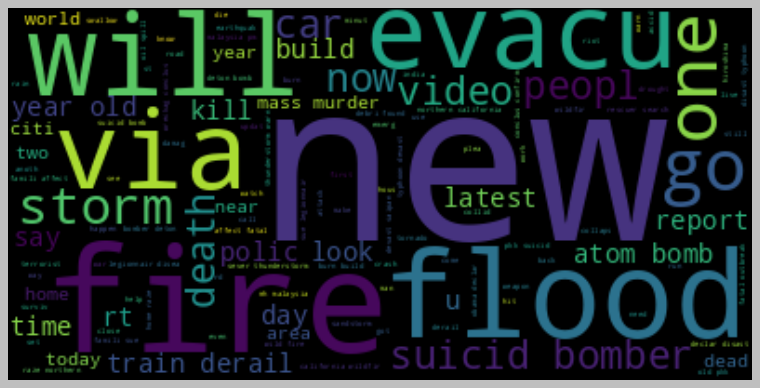

In [ ]:
X_disaster = X_train[y_train == 1]
text = " ".join(i for i in X_disaster["text"])
wordcloud = WordCloud(background_color="black").generate(text)
plt.style.use('classic')
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud of non-disaster tweets

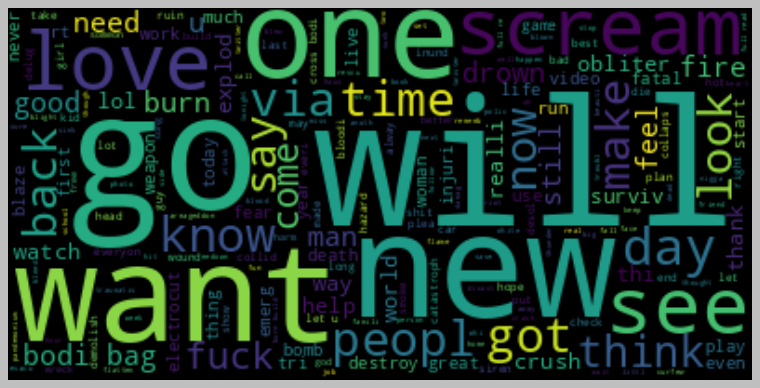

In [ ]:
X_disaster = X_train[y_train == 0]
text = " ".join(i for i in X_disaster["text"])
wordcloud = WordCloud(background_color="black").generate(text)
plt.style.use('classic')
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 4. Vectorize text data

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


class Vectorize(BaseEstimator, TransformerMixin):
  def __init__(self, vectorize):
    self.vectorize = vectorize
    self.tweets = [tweet.split() for tweet in X_train['text']]
    self.w2v_model = Word2Vec(self.tweets, vector_size=100, window=5, min_count=3, workers=4)
    self.tf_idf_model = TfidfVectorizer()
    self.tf_idf_model.fit(X_train['text'])

  def fit(self, X, y=None):
    return self

  def vectorize_with_word2vec(self, X):
    # Vectorize the text data
    w2v_matrix = []
    for tweet in X['text']:
      words = tweet.split()
      words_vecs = [self.w2v_model.wv[word] for word in words if word in self.w2v_model.wv]
      if len(words_vecs) == 0:
          words_vecs = np.zeros((1, 100))
      words_vecs = np.array(words_vecs)
      words_vecs = words_vecs.mean(axis=0)
      w2v_matrix.append(words_vecs)

    w2v_matrix = np.array(w2v_matrix)
    return pd.DataFrame(w2v_matrix)

  def vectorize_with_tfidf(self, X):
    # applying tf idf to training data
    X_train_tf = self.tf_idf_model.transform(X['text'])
    return X_train_tf

  def transform(self, X, y=None):
    if self.vectorize == 'tf-idf':
      return self.vectorize_with_tfidf(X)
    elif self.vectorize == 'word2vec':
      return self.vectorize_with_word2vec(X)


In [ ]:
vectorizer = Vectorize(vectorize='word2vec')
X_train_w2v = vectorizer.fit_transform(X_train)
X_train_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.088396,0.116534,0.070843,-0.004693,0.030997,-0.223280,0.067979,0.266975,-0.123939,-0.049181,...,0.153413,0.043108,0.026554,0.035675,0.241832,0.117294,0.103202,-0.164906,0.084184,-0.020946
1,-0.130243,0.168481,0.095462,-0.001808,0.041300,-0.313700,0.089078,0.387583,-0.169015,-0.068716,...,0.222666,0.067190,0.037985,0.046162,0.343034,0.168049,0.152229,-0.242779,0.116062,-0.028868
2,-0.161264,0.217777,0.123668,-0.003400,0.059483,-0.410859,0.116657,0.498777,-0.214412,-0.090978,...,0.285583,0.084868,0.045728,0.062699,0.450185,0.216332,0.199006,-0.313213,0.154189,-0.038332
3,-0.172272,0.206607,0.132331,-0.002946,0.050915,-0.387074,0.102366,0.477631,-0.194695,-0.096695,...,0.288165,0.074064,0.038445,0.059717,0.428213,0.212825,0.199723,-0.295508,0.155880,-0.042654
4,-0.105191,0.134571,0.077740,0.002528,0.035256,-0.254166,0.075263,0.320787,-0.138948,-0.057502,...,0.177908,0.049261,0.029678,0.038558,0.280919,0.135281,0.126547,-0.200425,0.100102,-0.020540


In [ ]:
vectorizer_tf = Vectorize(vectorize='tf-idf')
X_train_tf = vectorizer_tf.fit_transform(X_train)
X_train_tf.shape

(7613, 10944)

# 5. Traning and evaluate model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
models = {
    'Logistic_Regression': (
        LogisticRegression(),
        {
            'C': [0.1, 1.0, 10.0, 25.0],
            'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'],
            'max_iter': [100, 200]
        }
    ),
    'K Nearest Neighbors': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [5, 25, 50, 100],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    ),
    'Support Vector Machine': (
        LinearSVC(),
        {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': [0.1, 1.0, 10.0, 25.0],
            'max_iter': [1000, 2000]
        }
    ),
    'Naive Bayes': (
        MultinomialNB(),
         {
            'alpha': [0.1, 1.0, 10.0],
            'fit_prior': [True, False]
         }
    ),

    'Decision Tree': (
        DecisionTreeClassifier(),
        {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'min_samples_split': [2, 5, 7],
            'min_samples_leaf': [1, 3]
        }

    ),
    'Random Forest': (
        RandomForestClassifier(),
        {
            'n_estimators': [50, 100],
            'criterion': ['gini', 'entropy', 'log_loss'],
            'min_samples_split': [2, 5, 7],
            'min_samples_leaf': [1, 3]
        }
    )
}

In [ ]:
def get_best_models(models, vectorize):
  if vectorize == 'word2vector':
    X_train_gs = X_train_w2v
  if vectorize == 'tf-idf':
    X_train_gs = X_train_tf

  best_models = {}
  for model_name, model in models.items():
    params = model[1]
    model = model[0]
    try:
      grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
      grid_search.fit(X_train_gs, y_train)
      print(model_name)
      print("--------------------------------------------------------------------------")
      print('best score: ', grid_search.best_score_)
      print('best parameters: ', grid_search.best_params_)
      print("--------------------------------------------------------------------------", '\n')
      best_models[model_name] = (grid_search.best_estimator_, grid_search.best_params_)
    except Exception as e:
      print(f'{model_name}: {e}')

  return best_models

In [ ]:
import time

def visualize_results(best_models, xtrain, ytrain, xval, yval):
  results = {
        'model': [],
        'best_params': [],
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'time_running': []
    }

  fig, ax = plt.subplots(2, 3, figsize=(8, 6))
  i, j = (0, 0)

  for model_name, model in best_models.items():
    st = time.time()
    model[0].fit(xtrain, ytrain)
    # Predict probabilities for the test dataset
    y_predictions = model[0].predict(xval)
    # Calculate evaluation metrics
    accuracy = accuracy_score(yval, y_predictions)
    precision = precision_score(yval, y_predictions)
    recall = recall_score(yval, y_predictions)
    f1 = f1_score(yval, y_predictions)
    matrix_df = pd.DataFrame(confusion_matrix(yval, y_predictions))
    en = time.time()

    results['model'].append(model_name)
    results['best_params'].append(model[1])
    results['accuracy'].append(accuracy)
    results['recall'].append(recall)
    results['precision'].append(precision)
    results['f1'].append(f1)
    results['time_running'].append(en - st)

    ax[i][j].imshow(matrix_df, interpolation='nearest', cmap='Dark2')
    for u in range(len(matrix_df)):
      for v in range(len(matrix_df.columns)):
          text = ax[i][j].text(v, u, matrix_df.iloc[u, v], ha="center", va="center", color="w")
    ax[i][j].set_title(model_name, fontsize=10)
    ax[i][j].set_xticks([0, 1], labels=[0, 1])
    ax[i][j].set_yticks([0, 1], labels=[0, 1])
    if j < 2:
      j += 1
    else:
      j = 0
      i += 1

  plt.suptitle("Confusion Matrix")
  # plt.show()
  results = pd.DataFrame(results)
  results = results.style.highlight_max(subset=['accuracy', 'recall', 'precision', 'f1', 'time_running'], color = 'green')
  results = results.highlight_min(subset=['accuracy', 'recall', 'precision', 'f1', 'time_running'], color = 'red')
  return results

### 5.1 Evaluate models using vectorized data with word2vec

In [ ]:
import warnings
warnings.filterwarnings("ignore")

best_w2v_models = get_best_models(models, vectorize='word2vector')

Logistic_Regression
--------------------------------------------------------------------------
best score:  0.7099708111195571
best parameters:  {'C': 25.0, 'max_iter': 200, 'solver': 'lbfgs'}
-------------------------------------------------------------------------- 

K Nearest Neighbors
--------------------------------------------------------------------------
best score:  0.687378893756099
best parameters:  {'n_neighbors': 25, 'p': 2, 'weights': 'distance'}
-------------------------------------------------------------------------- 

Support Vector Machine
--------------------------------------------------------------------------
best score:  0.7305920692181125
best parameters:  {'C': 25.0, 'loss': 'squared_hinge', 'max_iter': 2000, 'penalty': 'l2'}
-------------------------------------------------------------------------- 

Naive Bayes: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below a

,model,best_params,accuracy,recall,precision,f1
0,Logistic_Regression,"{'C': 25.0, 'max_iter': 200, 'solver': 'lbfgs'}",0.741957,0.526570,0.767606,0.624642
1,K Nearest Neighbors,"{'n_neighbors': 25, 'p': 2, 'weights': 'distance'}",0.695338,0.381643,0.747634,0.505330
2,Support Vector Machine,"{'C': 25.0, 'loss': 'squared_hinge', 'max_iter': 2000, 'penalty': 'l2'}",0.750492,0.600644,0.738614,0.662522
3,Decision Tree,"{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}",0.652659,0.595813,0.570988,0.583136
4,Random Forest,"{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}",0.730138,0.531401,0.733333,0.616246


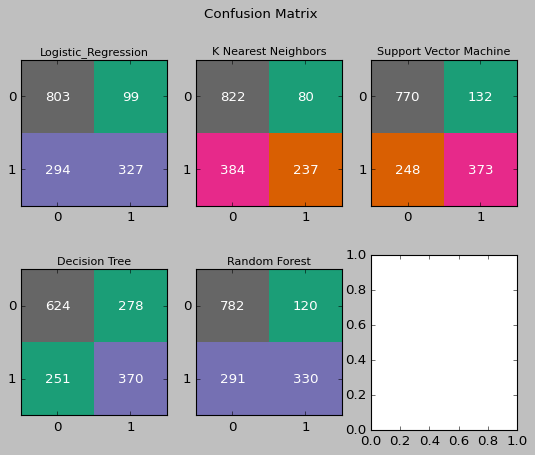

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(X_train_w2v, y_train, test_size=0.2)
results = visualize_results(best_w2v_models, xtrain, ytrain, xval, yval)
results

### 5.2 Evaluate models using vectorized data with tf-idf

In [ ]:
import warnings
warnings.filterwarnings("ignore")
best_tf_models = get_best_models(models, vectorize='tf-idf')

Logistic_Regression
--------------------------------------------------------------------------
best score:  0.8096668429676196
best parameters:  {'C': 1.0, 'max_iter': 100, 'solver': 'newton-cg'}
-------------------------------------------------------------------------- 

K Nearest Neighbors
--------------------------------------------------------------------------
best score:  0.7931162386982605
best parameters:  {'n_neighbors': 50, 'p': 2, 'weights': 'distance'}
-------------------------------------------------------------------------- 

Support Vector Machine
--------------------------------------------------------------------------
best score:  0.8083532139261072
best parameters:  {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
-------------------------------------------------------------------------- 

Naive Bayes
--------------------------------------------------------------------------
best score:  0.8032310528963255
best parameters:  {'alpha': 1.0, 'fit_p

,model,best_params,accuracy,recall,precision,f1,time_running
0,Logistic_Regression,"{'C': 1.0, 'max_iter': 100, 'solver': 'newton-cg'}",0.819435,0.672524,0.857434,0.753805,0.052922
1,K Nearest Neighbors,"{'n_neighbors': 50, 'p': 2, 'weights': 'distance'}",0.812869,0.675719,0.837624,0.748011,1.135075
2,Support Vector Machine,"{'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}",0.817466,0.661342,0.862500,0.748644,0.017964
3,Naive Bayes,"{'alpha': 1.0, 'fit_prior': True}",0.816809,0.682109,0.842209,0.753751,0.008834
4,Decision Tree,"{'criterion': 'log_loss', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}",0.762311,0.662939,0.733216,0.696309,1.014880
5,Random Forest,"{'criterion': 'log_loss', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}",0.806960,0.698083,0.806273,0.748288,11.577142


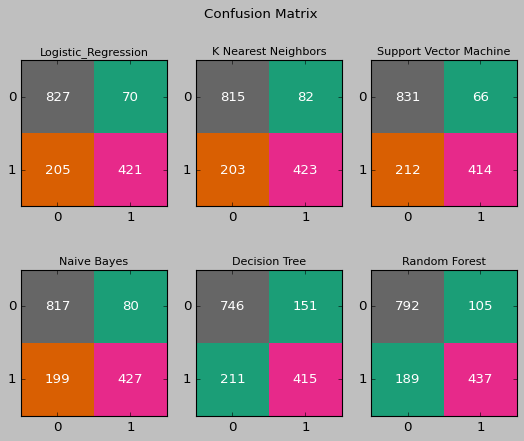

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(X_train_tf, y_train, test_size=0.2)
results = visualize_results(best_tf_models, xtrain, ytrain, xval, yval)
results

### Logistic Regression with different thresholds

,threshold,accuracy,recall,precision,f1
0,0.250000,0.621799,0.945687,0.522046,0.672727
1,0.300000,0.685489,0.883387,0.576642,0.697792
2,0.350000,0.752462,0.833866,0.656604,0.734694
3,0.400000,0.801051,0.777955,0.748080,0.762725
4,0.450000,0.815496,0.728435,0.804233,0.764459
5,0.500000,0.819435,0.672524,0.857434,0.753805


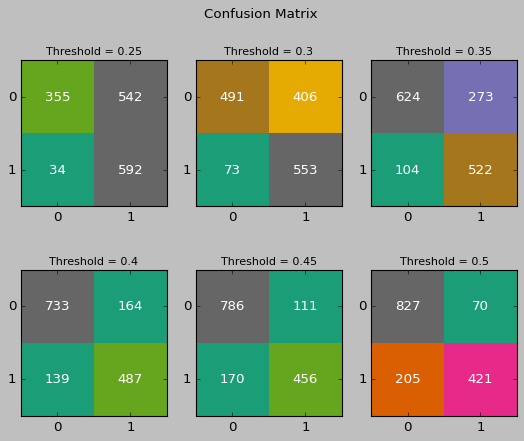

In [ ]:
best_logistic_model = best_tf_models['Logistic_Regression'][0]
thresholds = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
best_logistic_model.fit(xtrain, ytrain)
# Predict probabilities for the test dataset
y_probabilities = best_logistic_model.predict_proba(xval)[:, 1]
log_results = {
    'threshold': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': []
}
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
i, j = (0, 0)

for threshold in thresholds:
  y_predictions = pd.Series((y_probabilities > threshold).astype(int))
  # Calculate evaluation metrics
  accuracy = accuracy_score(yval, y_predictions)
  precision = precision_score(yval, y_predictions)
  recall = recall_score(yval, y_predictions)
  f1 = f1_score(yval, y_predictions)
  matrix_df = pd.DataFrame(confusion_matrix(yval, y_predictions))

  log_results['threshold'].append(threshold)
  log_results['accuracy'].append(accuracy)
  log_results['recall'].append(recall)
  log_results['precision'].append(precision)
  log_results['f1'].append(f1)

  ax[i][j].imshow(matrix_df, interpolation='nearest', cmap='Dark2')
  for u in range(len(matrix_df)):
    for v in range(len(matrix_df.columns)):
        text = ax[i][j].text(v, u, matrix_df.iloc[u, v], ha="center", va="center", color="w")
  ax[i][j].set_title(f'Threshold = {threshold}', fontsize=10)
  ax[i][j].set_xticks([0, 1], labels=[0, 1])
  ax[i][j].set_yticks([0, 1], labels=[0, 1])
  if j < 2:
    j += 1
  else:
    j = 0
    i += 1

plt.suptitle("Confusion Matrix")
log_results = pd.DataFrame(log_results)
log_results = log_results.style.highlight_max(subset=['accuracy', 'recall', 'precision', 'f1'], color = 'green')
log_results = log_results.highlight_min(subset=['accuracy', 'recall', 'precision', 'f1'], color = 'red')
log_results

# 6. Using best model to predict test data

After training and evaluating step, we decided to choose Logistic Regression model with threshold = 0.45 is the best model for classification and tf-idf is the vectorize method for text data.

### 6.1 Retraining model with whole traing set

In [ ]:
best_logistic_model = best_tf_models['Logistic_Regression'][0]
best_logistic_model.fit(X_train_tf, y_train)

LogisticRegression(solver='newton-cg')

### 6.2 Evaluate on test set

In [ ]:
test = pd.read_excel('./drive/MyDrive/Colab Notebooks/test_Checked.xlsx')
X_test = test[['text']]
y_test = test['target']

In [ ]:
# Cleaning and vectorize X_test
text_preprocessing_pipeline = Pipeline([
    ('correct_typos_and_slang', CorrectTyposAndSlang()),
    ('expand_contractions', ExpandContractions()),
    ('remove_noise', RemoveNoise()),
    ('stem_and_lemitize', StemAndLemitize()),
])

X_test = text_preprocessing_pipeline.fit_transform(X_test)
X_test_tf = vectorizer_tf.transform(X_test)
X_test_tf.shape

(3263, 10944)

In [ ]:
y_test[y_test.isna()]

Series([], Name: target, dtype: int64)

In [ ]:
y_test_probabilities = best_logistic_model.predict_proba(X_test_tf)[:, 1]
threshold = 0.45
y_test_predictions =  pd.Series((y_test_probabilities > threshold).astype(int))
y_test_predictions
accuracy = accuracy_score(y_test, y_test_predictions)
precision = precision_score(y_test, y_test_predictions)
recall = recall_score(y_test, y_test_predictions)
f1 = f1_score(y_test, y_test_predictions)
matrix_df = pd.DataFrame(confusion_matrix(y_test, y_test_predictions))

Accuracy:  0.7572785779957095
Precision:  0.5553822152886115
Recall:  0.7623126338329764
F1:  0.6425992779783393


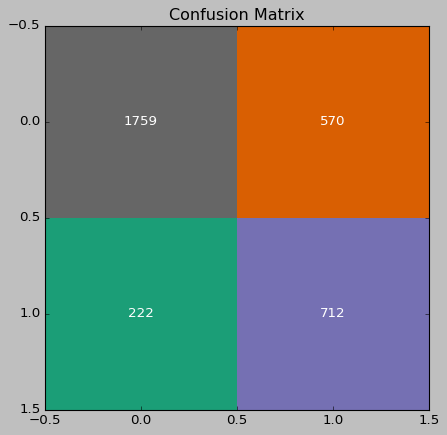

In [ ]:
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)
plt.imshow(matrix_df, interpolation='nearest', cmap='Dark2')
for u in range(len(matrix_df)):
  for v in range(len(matrix_df.columns)):
      text = plt.text(v, u, matrix_df.iloc[u, v], ha="center", va="center", color="w")
plt.title('Confusion Matrix')
plt.show();